## Run this notebook

You can launch this notebook in VEDA JupyterHub by clicking the link below.

[Launch in VEDA JupyterHub (requires access)](https://hub.openveda.cloud/hub/user-redirect/git-pull?repo=https://github.com/NASA-IMPACT/veda-docs&urlpath=lab/tree/veda-docs/user-guide/notebooks/veda-operations/stac-collection-creation.ipynb&branch=main) 

<details><summary>Learn more</summary>
    
### Inside the Hub

This notebook was written on a VEDA JupyterHub instance

See (VEDA Analytics JupyterHub Access)[https://nasa-impact.github.io/veda-docs/veda-jh-access.html] for information about how to gain access.

### Outside the Hub

You are welcome to run this anywhere you like (Note: alternatively you can run this on https://daskhub.veda.smce.nasa.gov/, MAAP, locally, ...), just make sure that the data is accessible, or get in contact with the VEDA team to enable access.

</details>

## Install extra packages

In [1]:
!pip install -U pystac nbss-upload --quiet

In [3]:
from datetime import datetime
import pystac

## Create `pystac.Collection`

In this section we will be creating a `pystac.Collection` object. This is the part of that notebook that you should update.

### Declare constants

Start by declaring some string and boolean fields.

In [4]:
COLLECTION_ID = "alos2-all-vars-daily-test"
TITLE = "ALOS2 All Variables daily timestep"
DESCRIPTION = (
    "The Advanced Land Observing Satellite-2 (ALOS-2, DAICHI-2) is a follow-on mission "
    "from the ALOS Daichi. ALOS has contributed to cartography, regional observation, "
    "disaster monitoring, and resource surveys, since its launch in 2006. ALOS-2 will "
    "succeed this mission with enhanced capabilities. JAXA conducted research and "
    "development activities for ALOS-2 to improve wide and high-resolution observation "
    "technologies developed for ALOS in order to further fulfill social needs. These "
    "social needs include: 1) Disaster monitoring of damage areas, both in considerable "
    "detail, and when these areas may be large 2) Continuous updating of data archives "
    "related to national land and infrastructure information 3) Effective monitoring of "
    "cultivated areas 4) Global monitoring of tropical rain forests to identify carbon sinks."
)
#don't change TENANT
TENANT = ["nasa-disasters"]
DASHBOARD__IS_PERIODIC = False #There is no regular periodicity to the files
DASHBOARD__TIME_INTERVAL = "P1D" #The files are of daily data
#don't change LICENSE
LICENSE = "CC0-1.0"

You can find the files you will be generating collections with here: https://data.disasters.openveda.cloud/browseui/browseui/browseui/browseui/browseui/browseui/#drcs_activations_new/ 

With these files, you can determine what to put for the above constants ```DASHBOARD__IS_PERIODIC``` and ```DASHBOARD__TIME_INTERVAL```.

### Finding Data Information

To find much of the information that will be inserted below, you can copy the files you're making a collection out of from ```drcs_activations_new```.

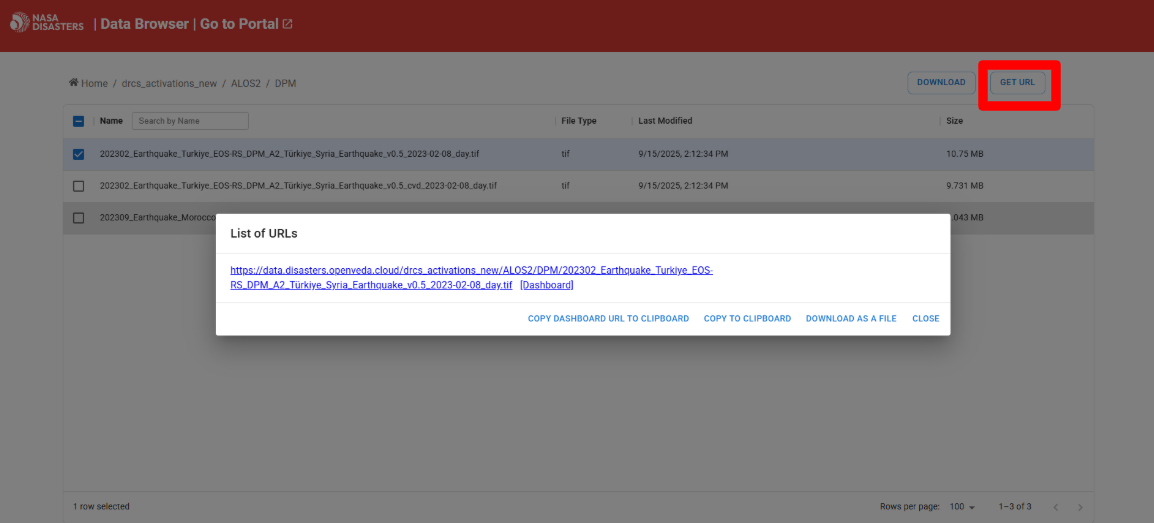

Select one of the files, click ```GET URL``` in the upper right corner, and copy the url. Then, you can paste the URL into the prompt when clicking this link: https://dev.openveda.cloud/api/raster/cog/viewer.

At this point, you should be be able to see relevant information about the data. We'll discuss this data in upcoming sections.

### Extents

The extents indicate the start (and potentially end) times of the data as well as the footprint of the data.

The spatial extent is only relevant for its presentation on the STAC browser (https://openveda.cloud). So, when selecting the spatial extent, you can look at the bounding box surrounding the data. 

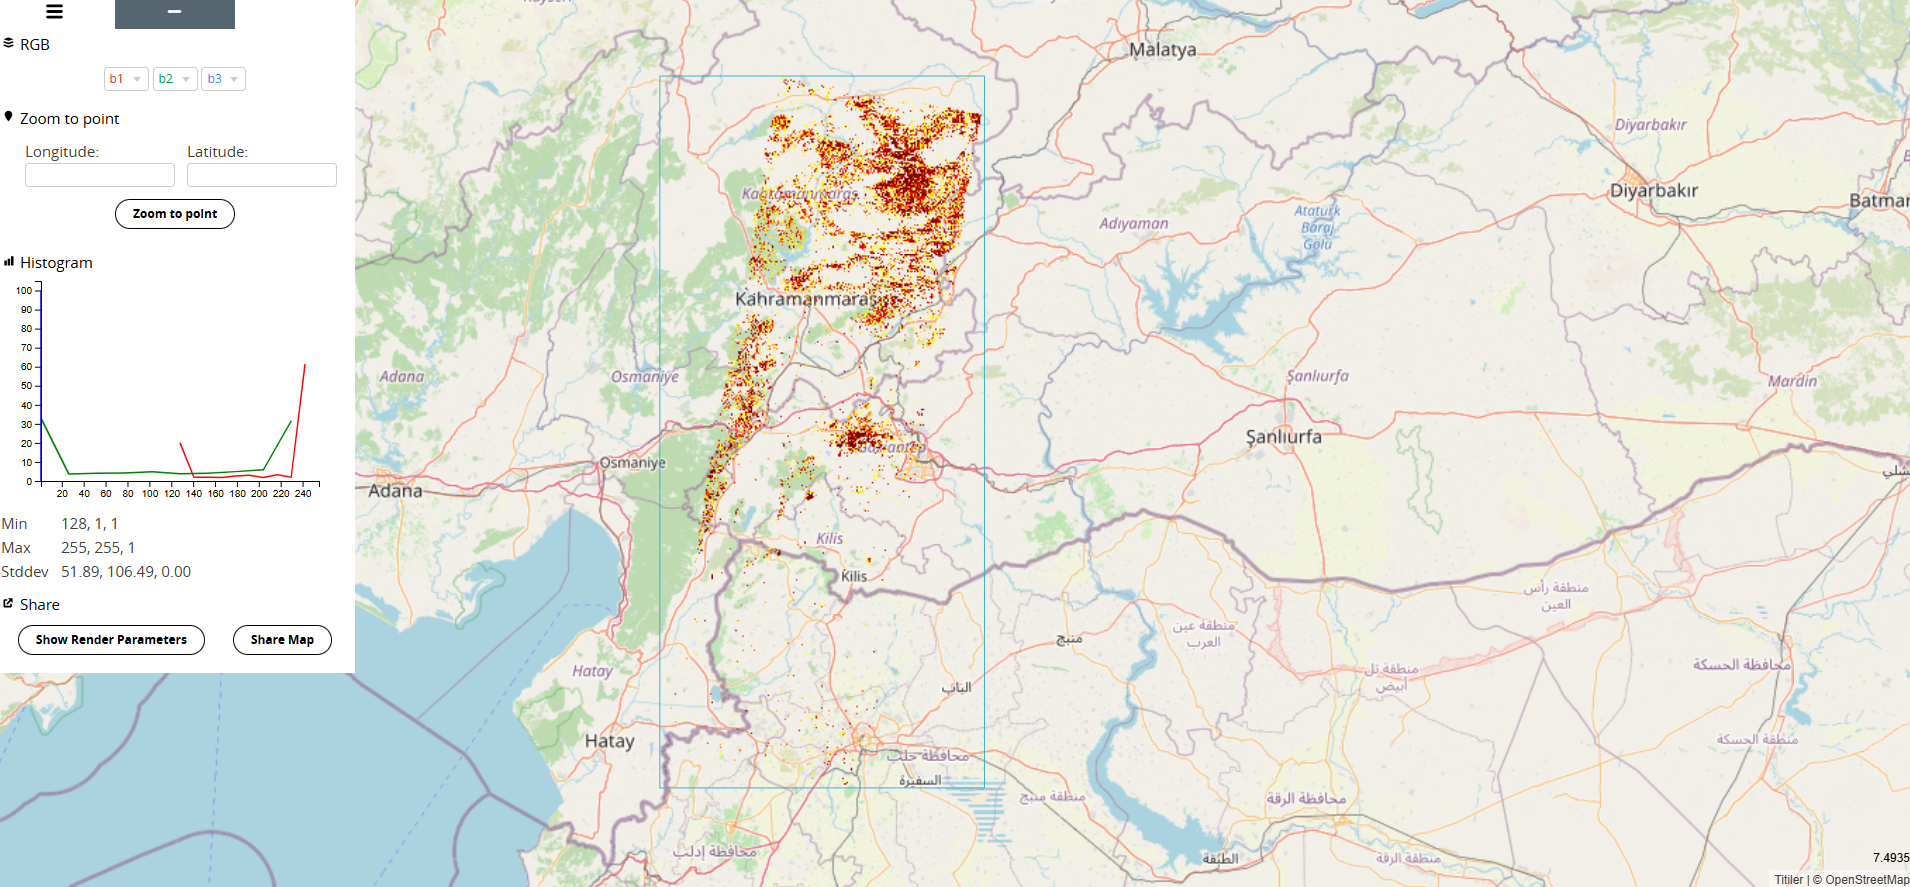

Based on this box, you can estimate the corrdinates by selecting points on Google Maps. If you have multiple files in the collection that cover different parts of the world, you can select a large portion of the globe, or even the entire Earth.

The temporal extent is simply determined by the files you're selecting for your collection, and date information is contained within the name of the file.

In [5]:
extent=pystac.Extent(
    ##spatial extent only matters in the STAC browser, can be estimated when looking at the map, if the items are all over the place, do the whole world
        spatial=pystac.SpatialExtent([[36.354403495, 36.053110292, 37.621070162, 38.266165847]]),
        temporal=pystac.TemporalExtent([[datetime.fromisoformat("2023-02-08T00:00:00+00:00"), datetime.fromisoformat("2023-02-08T00:00:00+00:00")]]),
    )

### Providers

We know that the data host, processor, and producter is "NASA".

In [6]:
providers = [
    pystac.Provider(
        name="NASA",
    )
]

### Renders

Renders provides visualization information. In this example, there are two visualization styles corresponding to two assets:

1. ```dpm```: Damage Proxy Map render.
2. ```dpm-cvd```: Color Vision Deficiency render.

```bidx``` describes which bands are in the file.

```rescale``` shows how to scale the pixels (0-255 is a typical RGB color rescale). This is used by the VEDA UI.

In the below image, we see where to find this information. By selecting one of the dropdown menus highlighted in the red box, you will see how many bands are used in this data. By looking at the information in the blue box, you will see the pixel values that will determine your ```rescale```.

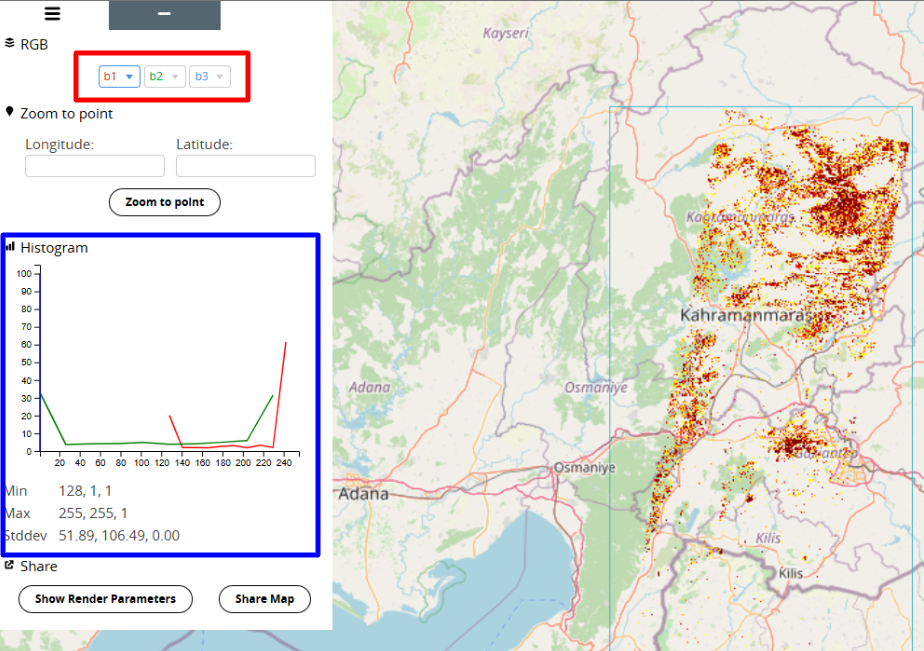

In [7]:
renders = {
    ##describe how to find this info
        "dpm": {
            "bidx": [1, 2, 3, 4],
            "assets": ["dpm"],
            "rescale": [[0, 255]]
        },
        "dpm-cvd": {
            "bidx": [1, 2, 3, 4],
            "assets": ["dpm-cvd"],
            "rescale": [[0, 255]]
        }
    }

### Item Assets

Assets are types of data stored in this collection, and this variable stores metadata about the item assets. The two assets below correspond to the two ```renders``` styles.

Here, the ```type``` and ```roles``` should remain the same.

In [8]:
item_assets = {
        "dpm": {
            "type": "image/tiff; application=geotiff; profile=cloud-optimized",
            "roles": ["data", "layer"],
            "title": "Damage Proxy Map",
            "description": (
                "Damage Proxy Map derived from ALOS-2 SAR data showing changes in radar "
                "backscatter that indicate potential structural damage or building destruction "
                "from disaster events."
            ),
        },
        "dpm-cvd": {
            "type": "image/tiff; application=geotiff; profile=cloud-optimized",
            "roles": ["data", "layer"],
            "title": "Damage Proxy Map (CVD)",
            "description": (
                "Damage Proxy Map with colorblind-friendly color scheme, derived from ALOS-2 "
                "SAR data showing changes in radar backscatter indicating potential structural "
                "damage or building destruction."
            ),
        }
    }

### Discovery Items

The information included here will detail how to find your files and build STAC Item IDs for them. Most items are self-explanatory, but the regex are tricky. You need to construct a regex pattern that will fit all of the files you're including in your collection. To determine the regex in this example:

For the ```dpm``` asset regex:
*  Must contain ```DPM```
*  Must end with ```.tif```
*  Must NOT contain ```_cvd_``` (negative lookahead)
*  So: the standard Damage Proxy Map raster.

For the ```dpm-cvd``` asset regex:
*  Must contain ```DPM```
*  Must contain ```cvd```
*  Must end with ```.tif```
*  So these are colorblind-friendly (CVD) versions of the DPM.

For the Item ID construction:
This extracts the date string from the filename.

In [9]:
discovery_items = {
    "collection": "alos2-all-vars-daily", # Change based on your collection
    "bucket": "nasa-disasters", # Always nasa-disasters
    "prefix": "drcs_activations_new/ALOS2/", # Change based on your collection
    "discovery": "s3", # Always s3
    "filename_regex": ".*_day.tif$",
    # Under assets, you can use the same description and title you already created for item_assets
    "assets": {
        "dpm": {
            "description": "Damage Proxy Map derived from ALOS-2 SAR data showing changes in radar backscatter that indicate potential structural damage or building destruction from disaster events.",
            "regex": "^(?!.*(_cvd_)).*DPM.*\\.tif$",
            "title": "Damage Proxy Map"
        },
        "dpm-cvd": {
            "description": "Damage Proxy Map with colorblind-friendly color scheme, derived from ALOS-2 SAR data showing changes in radar backscatter indicating potential structural damage or building destruction.",
            "regex": ".*DPM.*cvd.*\\.tif$",
            "title": "Damage Proxy Map (CVD)"
        }
    },
    "id_regex": ".*(\\d{4}-\\d{2}-\\d{2}_day)\\.tif$",
    "id_template": "alos2-{}"
}

### Put it together

Now take your constants and the extents and providers and create a `pystac.Collection`

In [10]:
collection = pystac.Collection(
    id=COLLECTION_ID,
    title=TITLE,
    extent=extent,
    license=LICENSE,
    providers=providers,
    description=DESCRIPTION,
    extra_fields={
        #add discovery items here
        "tenant": TENANT,
        "renders": renders,
        "item_assets": item_assets,
        "dashboard:is_periodic": DASHBOARD__IS_PERIODIC,
        "dashboard:time_interval": DASHBOARD__TIME_INTERVAL,
        "discovery_items": discovery_items,
    },
)

### Stac Extensions

These links provide additional fields and metedata about the data in the collection.

In [18]:
collection.stac_extensions = [
    "https://stac-extensions.github.io/render/v1.0.0/schema.json", #informnation about visualizing
    "https://stac-extensions.github.io/item-assets/v1.0.0/schema.json", #collection level asset templates
]

### Try it out!

Now that you have a collection you can try it out and make sure that it looks how you expect and that it passes validation checks.

In [19]:
collection.validate()

['https://schemas.stacspec.org/v1.1.0/collection-spec/json-schema/collection.json',
 'https://stac-extensions.github.io/render/v1.0.0/schema.json',
 'https://stac-extensions.github.io/item-assets/v1.0.0/schema.json']

In [13]:
collection.to_dict()

{'type': 'Collection',
 'id': 'alos2-all-vars-daily-test',
 'stac_version': '1.1.0',
 'description': 'The Advanced Land Observing Satellite-2 (ALOS-2, DAICHI-2) is a follow-on mission from the ALOS Daichi. ALOS has contributed to cartography, regional observation, disaster monitoring, and resource surveys, since its launch in 2006. ALOS-2 will succeed this mission with enhanced capabilities. JAXA conducted research and development activities for ALOS-2 to improve wide and high-resolution observation technologies developed for ALOS in order to further fulfill social needs. These social needs include: 1) Disaster monitoring of damage areas, both in considerable detail, and when these areas may be large 2) Continuous updating of data archives related to national land and infrastructure information 3) Effective monitoring of cultivated areas 4) Global monitoring of tropical rain forests to identify carbon sinks.',
 'links': [],
 'stac_extensions': ['https://stac-extensions.github.io/render

## Publish to STAC
Now that you have validated your dataset, you can initiate a workflow and publish the dataset to the VEDA Platform.

In the Form page of the Ingest UI, you can click Submit to submit your data ingestion.

Congratulations! You have now successfully uploaded a COG dataset to the VEDA Dashboard. You can now explore the data catalog to verify the ingestion process has worked successfully, as now uploaded data should be ready for viewing and exploration.

In [21]:
# Boilerplate ingest example
# Content Curation --> Dataset Ingestion --> Boilerplate Ingest Example